In [98]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [119]:
coinc_counts = np.loadtxt('../data/20241003-gamma2.TKA', unpack=True)
all_counts = np.loadtxt('../data/co57_G20.TKA', unpack=True)
bins = np.arange(0, len(all_counts))
idx = slice(120, 160)
coinc_counts = coinc_counts[idx]
all_counts = all_counts[idx]
bins = bins[idx]

In [162]:
normalization_factor_all = np.max(all_counts)
normalized_all = all_counts / normalization_factor_all
normalized_coinc = coinc_counts / np.max(coinc_counts) * 0.88

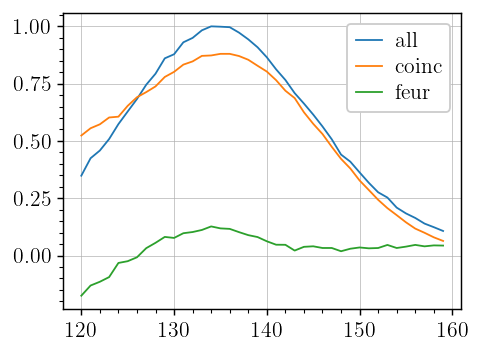

In [163]:
plt.plot(bins, normalized_all, label='all')
plt.plot(bins, normalized_coinc, label='coinc')
plt.plot(bins, normalized_all - normalized_coinc, label='feur')
plt.legend()
# plt.xlim(0, 300)

In [101]:
normalization_factor_all = np.sum(all_counts)
normalized_all = all_counts / normalization_factor_all
normalized_coinc = coinc_counts / normalization_factor_all * 0.88

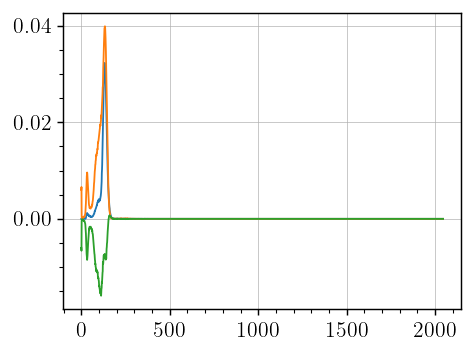

In [102]:
plt.plot(normalized_all)
plt.plot(normalized_coinc)
# plt.plot(normalized_all - normalized_coinc)